In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle
import matplotlib.pyplot as plt

In [2]:
weather = pd.read_csv("../weather_observations.csv")
weather['timestamp'] = pd.to_datetime(weather['timestamp'], format="%Y%m%d%H%M%S")
weather.sort_values('timestamp')
weather.set_index('timestamp')

n = weather.shape[0]

TRAIN_SPLIT = int(np.floor(n*0.75))

apparent_temperature = weather['apparent_temperature'].astype(float)
endog = apparent_temperature

In [3]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 48)

model = SARIMAX(endog = endog[:TRAIN_SPLIT], 
            order = order, 
            seasonal_order = seasonal_order, 
            enforce_stationarity = True)
results = model.fit(disp = False)

with open('sarimax_base_model.pkl', 'wb') as f:
    pickle.dump(results, f)

/home/chloekoee/imc/mockBomex/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chloekoee/imc/mockBomex/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chloekoee/imc/mockBomex/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


### Incremental Forecasting and Refitting

In [27]:
with open('sarimax_base_model.pkl', 'rb') as f:
    cached_results = pickle.load(f)

predictions = []
actuals = []
confidence_interval = []
NUM_STEPS = 4
END_RANGE = TRAIN_SPLIT + 16#n

for i in range(TRAIN_SPLIT, END_RANGE, NUM_STEPS): 
    forecast = cached_results.get_forecast(steps = NUM_STEPS)
    predictions.append(forecast.predicted_mean.iloc[NUM_STEPS-1])
    actuals.append(endog.iloc[i])
    confidence_interval.append(forecast.conf_int(alpha=0.05).iloc[NUM_STEPS-1].to_dict()) # 95% confidence interval
    cached_results = cached_results.append(endog = [endog.iloc[i]], refit = False)
    


3
216    19.551111
217    19.055722
218    19.129423
219    19.256075
Name: predicted_mean, dtype: float64
19.256075110072832
{'lower apparent_temperature': 17.11955455217687, 'upper apparent_temperature': 21.98266730037692}
3
217    19.222985
218    19.313174
219    19.454626
220    18.904400
Name: predicted_mean, dtype: float64
18.90440045520654
{'lower apparent_temperature': 16.791428407257424, 'upper apparent_temperature': 21.654540699016}
3
218    16.478850
219    16.340882
220    15.539884
221    15.110001
Name: predicted_mean, dtype: float64
15.110001072540374
{'lower apparent_temperature': 14.047294176999497, 'upper apparent_temperature': 18.910405849221316}
3
219    15.241240
220    14.331836
221    13.804660
222    13.821315
Name: predicted_mean, dtype: float64
13.821314965383504
{'lower apparent_temperature': 12.80968501297481, 'upper apparent_temperature': 17.672795868719334}


### Plotting Forecast & Confidence

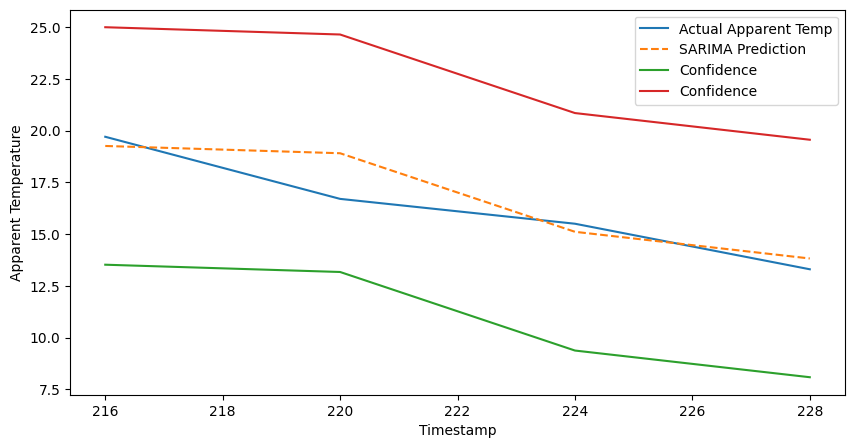

In [28]:
# time_index = endog.index[TRAIN_SPLIT:n]
time_index = endog.index[TRAIN_SPLIT:TRAIN_SPLIT+16:NUM_STEPS]
confidence = pd.DataFrame(confidence_interval)

plt.figure(figsize=(10, 5))
plt.plot(time_index, actuals, label='Actual Apparent Temp')
plt.plot(time_index, predictions, label='SARIMA Prediction', linestyle='--')
plt.plot(time_index, confidence, label = 'Confidence')
plt.xlabel('Timestamp')
plt.ylabel('Apparent Temperature')
plt.legend()
plt.show()


### Plot Model 
Setting `dynamic = False` plots the models predictions for each timestamp where $\text{prediction}_t$ uses $\text{observed}_{t-1}$ rather than $\text{prediction}_{t-1}$

If want to evaluate model's prediction for longer time horizons set start and end to capture horizon, and set dynamic = True

The model will gradually get worse as errors compound (from successively using prediction values rather than observation values)

<Axes: >

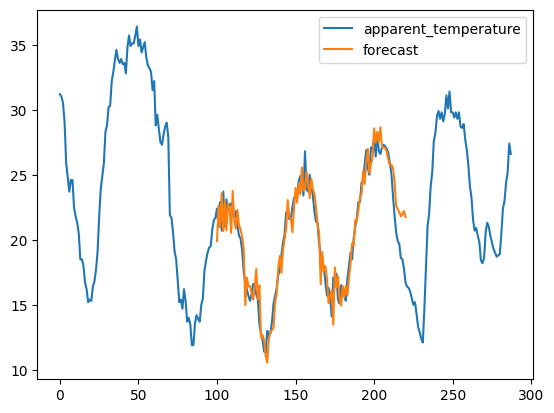

In [14]:
weather['forecast'] = cached_results.predict(start=100, end=220, dynamic=(100))
weather[['apparent_temperature', 'forecast']].plot()


/home/chloekoee/imc/mockBomex/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


{'lower apparent_temperature': {216: 17.11955455217687, 217: 15.398649564009652, 218: 14.398710997890355, 219: 13.520742764428505, 220: 11.994646579271574, 221: 10.84594911319413, 222: 10.234389049378427, 223: 9.053872259850865, 224: 7.753346160374663, 225: 6.134057869555086, 226: 5.01314603544658, 227: 4.418419913462827, 228: 3.881827526043427, 229: 2.7672272487453355, 230: 2.3469522977678547, 231: 2.4746607033814065, 232: 2.3568327562597453, 233: 2.025482054913226, 234: 1.638575618406005, 235: 2.065205502557795, 236: 2.349849863083822, 237: 2.325655431137154, 238: 2.4687878647959884, 239: 2.1354558471516754, 240: 2.5773994751387086}, 'upper apparent_temperature': {216: 21.98266730037692, 217: 22.712795113168887, 218: 23.860134008667117, 219: 24.99140745571716, 220: 25.390489835363695, 221: 26.105705725952028, 222: 27.307787726145257, 223: 27.896445267900702, 224: 28.323951449506595, 225: 28.393643902807263, 226: 28.924127021094982, 227: 29.944363682860555, 228: 30.987306680925382, 22

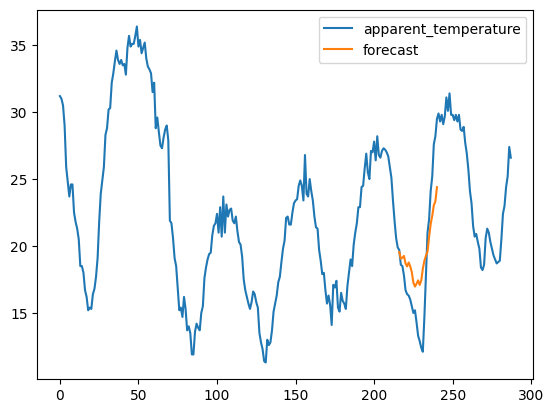

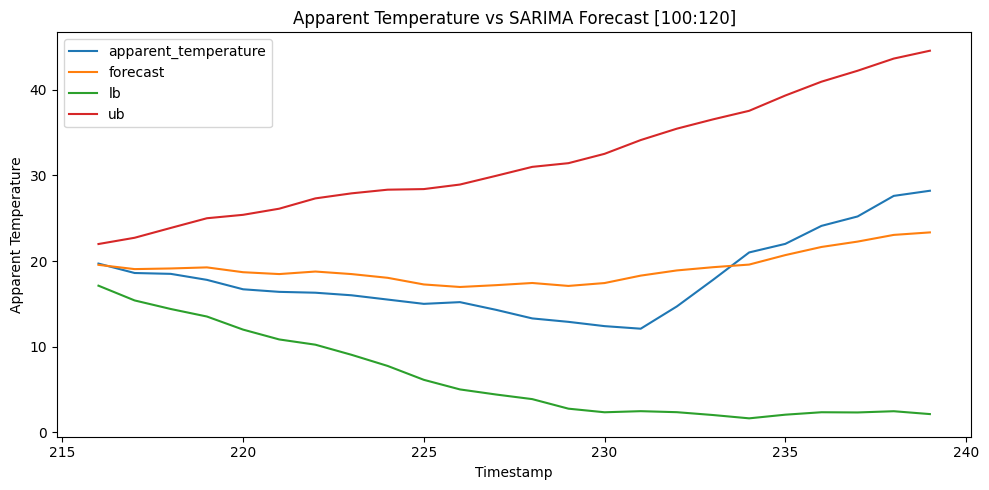

In [47]:

prediction = cached_results.get_prediction(start=TRAIN_SPLIT, end=TRAIN_SPLIT+24, dynamic=True, full_results = True)
weather['forecast'] = prediction.predicted_mean
weather['lb'] = prediction.conf_int().iloc[:,0]
weather['ub'] = prediction.conf_int().iloc[:,1]

start_idx = TRAIN_SPLIT
end_idx = TRAIN_SPLIT+24

weather.iloc[start_idx:end_idx][['apparent_temperature', 'forecast', 'lb', 'ub']].plot(figsize=(10, 5))
plt.xlabel('Timestamp')
plt.ylabel('Apparent Temperature')
plt.title('Apparent Temperature vs SARIMA Forecast [100:120]')
plt.legend()
plt.tight_layout()
plt.show()

